# Tutorial 1.2 - CME Solution of a Bimolecular Reaction

### Here we examine a stochastic version of Tutorial 1.1 using Chemical Master Equation.

We use pyLM to construct the CME system.

In order to use pyLM, we need to import several libraries.  The first is [```pyLM proper (pyLM)```](https://luthey-schulten.chemistry.illinois.edu/software/LM2.4/API.html).  The second [```pyLM.units```](https://luthey-schulten.chemistry.illinois.edu/software/LM2.4/_autosummary/pyLM.units.html#module-pyLM.units) is a library to convert number with given units, such as ```nm()```, ```micron()```, ```ms()```, ```microsecond()```, etc.  Finally, we import the [```pySTDLM```](https://luthey-schulten.chemistry.illinois.edu/software/LM2.4/_autosummary/pySTDLM.html#module-pySTDLM) standard library, which contains functionality used in biological simulations and post-processing commands including plotting. [```pySTDLM.PostProcessing```](https://luthey-schulten.chemistry.illinois.edu/software/LM2.4/_autosummary/pySTDLM.PostProcessing.html#module-pySTDLM.PostProcessing) module contains functions to get traces and plotting.

In [1]:
# Import Standard Python Libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# Import pyLM Libraries
from pyLM import *
from pyLM.units import *
from pySTDLM import *
from pySTDLM.PostProcessing import *

# Enable plotting inline in the Jupyter notebook
%matplotlib inline

In [2]:
# Constants
V  = 1.0e-15       # L
NA = 6.022e23      # molecules/mole
kf = 1.07e5/(NA*V) # /M/s
kr = 0.351         # /s

## Define a CME Simulation

See the [pyLM Documentation](https://luthey-schulten.chemistry.illinois.edu/software/LM2.4/API.html)

We begin by creating a [CMESimulation](https://luthey-schulten.chemistry.illinois.edu/software/LM2.4/_autosummary/pyLM.CME.html#module-pyLM.CME) "object" that we call ```sim```. This object will include the definition of the whole stochastic simulation.

In [3]:
# Create our CME simulation object
sim = CME.CMESimulation(name='Bimolecule Reaction')

Next we define the chemical species with simulation. First. we specify the names of the chemical species.  Then we register these species with the simulation.  The [```defineSpecies()```](https://luthey-schulten.chemistry.illinois.edu/software/LM2.4/_autosummary/pyLM.CME.html#module-pyLM.CME) function can be called multiple times and will add any new names to the list of species.


In [4]:
# Define our chemical species
species = ['A', 'B', 'C']
sim.defineSpecies(species)

Here we add reactions to the simulation. We use the [```addReaction()```](https://luthey-schulten.chemistry.illinois.edu/software/LM2.4/_autosummary/pyLM.CME.html#module-pyLM.CME) function that is a member of the ```CMESimulation``` object. We add a bimolecular association reaction and a unimolecular dissociation reaction. When more than one reactant is involved, the list of reactant names should be passed as a tuple as can be seen in the reactant of the association reaction. The rates in this command must be in units of molecules and seconds, for instance units of ```/molecule/sec``` for the association reaction.


In [5]:
# Add reactions to the simulation
sim.addReaction(reactant=('A','B'), product='C', rate=kf)
sim.addReaction(reactant='C', product=('A','B'), rate=kr)

Next, we add the initial particle counts to the simulation using the [```addParticles()```](https://luthey-schulten.chemistry.illinois.edu/software/LM2.4/_autosummary/pyLM.CME.html#module-pyLM.CME) function.

In [6]:
# Set our initial species counts
sim.addParticles(species='A', count=1000)
sim.addParticles(species='B', count=1000)
sim.addParticles(species='C', count=0)

Finally, we define the simulation execution parameters. We have the simulation run for 30 seconds of real time saving results every 30 microseconds for a total of 1 million times. <br/>

Then we name the simulation output file and save the simulation definition to it.

In [7]:
# Define simulation parameters: run for 30 seconds, saving data every 30 ms
sim.setWriteInterval(microsecond(30))
sim.setSimulationTime(30)
filename = "./T1.2-bimol.lm"
os.system("rm -rf %s"%(filename)) 
sim.save(filename)

In [8]:
# Print simulation parameters to the notebook
sim

Specie,Particle ID,Initial Count
A,1,1000
B,2,1000
C,3,0
Reaction,Rate,Units
A + B ⟶ C,0.0001776818332779807,molecule⁻¹sec⁻¹
C ⟶ A + B,0.351,s⁻¹


## Run Simulation with Different Replicates Number

Next we run the simulation. To do this, we specify which file has the problem specification (as saved two cells up). Lattice Microbes supports several different solvers for CME simulations; here we use the most common algorithm called the Gillespie's algorithm (aka the Stochastic Simulation Algorithm). You can learn more from Gillespie's [review paper](https://www.annualreviews.org/content/journals/10.1146/annurev.physchem.58.032806.104637) and [wikipedia page](https://en.wikipedia.org/wiki/Gillespie_algorithm).

Because the CME represents a stochastic process, each instance of a simulation will have a slightly different trajectory.  Generally, we run many "replicate" simulations with the same or nearly the same starting conditions and then compute aggregate statistics over all of them.

In [9]:
# Run reps replicates using the Gillespie solver
reps = 200

sim.run(filename=filename, method="lm::cme::GillespieDSolver", replicates=reps)

  0%|                                                                                                                                                                                      | 0/200 [00:00<?, ?it/s]

2024-05-02 10:54:42) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:42) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:42) Info: Data output thread running.
2024-05-02 10:54:42) Info: Seeding xorwow rng with top word 1 and bottom word 829542915
2024-05-02 10:54:42) Info: Data output thread finished.
2024-05-02 10:54:42) Info: Simulation file closed.


  0%|8                                                                                                                                                                             | 1/200 [00:00<00:51,  3.89it/s]

2024-05-02 10:54:42) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:42) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:42) Info: Data output thread running.
2024-05-02 10:54:42) Info: Seeding xorwow rng with top word 2 and bottom word 969015525
2024-05-02 10:54:43) Info: Data output thread finished.
2024-05-02 10:54:43) Info: Simulation file closed.


  1%|#7                                                                                                                                                                            | 2/200 [00:00<00:36,  5.47it/s]

2024-05-02 10:54:43) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:43) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:43) Info: Data output thread running.
2024-05-02 10:54:43) Info: Seeding xorwow rng with top word 3 and bottom word 99935890
2024-05-02 10:54:43) Info: Data output thread finished.
2024-05-02 10:54:43) Info: Simulation file closed.


  2%|##6                                                                                                                                                                           | 3/200 [00:00<00:30,  6.39it/s]

2024-05-02 10:54:43) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:43) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:43) Info: Data output thread running.
2024-05-02 10:54:43) Info: Seeding xorwow rng with top word 4 and bottom word 224480143
2024-05-02 10:54:43) Info: Data output thread finished.
2024-05-02 10:54:43) Info: Simulation file closed.


  2%|###4                                                                                                                                                                          | 4/200 [00:00<00:27,  7.02it/s]

2024-05-02 10:54:43) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:43) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:43) Info: Data output thread running.
2024-05-02 10:54:43) Info: Seeding xorwow rng with top word 5 and bottom word 345295228
2024-05-02 10:54:43) Info: Data output thread finished.
2024-05-02 10:54:43) Info: Simulation file closed.


  2%|####3                                                                                                                                                                         | 5/200 [00:00<00:26,  7.40it/s]

2024-05-02 10:54:43) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:43) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:43) Info: Data output thread running.
2024-05-02 10:54:43) Info: Seeding xorwow rng with top word 6 and bottom word 468201525
2024-05-02 10:54:43) Info: Data output thread finished.
2024-05-02 10:54:43) Info: Simulation file closed.


  3%|#####2                                                                                                                                                                        | 6/200 [00:00<00:25,  7.53it/s]

2024-05-02 10:54:43) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:43) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:43) Info: Data output thread running.
2024-05-02 10:54:43) Info: Seeding xorwow rng with top word 7 and bottom word 596200481
2024-05-02 10:54:43) Info: Data output thread finished.
2024-05-02 10:54:43) Info: Simulation file closed.


  4%|######                                                                                                                                                                        | 7/200 [00:01<00:25,  7.65it/s]

2024-05-02 10:54:43) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:43) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:43) Info: Data output thread running.
2024-05-02 10:54:43) Info: Seeding xorwow rng with top word 8 and bottom word 722833917
2024-05-02 10:54:43) Info: Data output thread finished.
2024-05-02 10:54:43) Info: Simulation file closed.


  4%|######9                                                                                                                                                                       | 8/200 [00:01<00:24,  7.81it/s]

2024-05-02 10:54:43) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:43) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:43) Info: Data output thread running.
2024-05-02 10:54:43) Info: Seeding xorwow rng with top word 9 and bottom word 844789936
2024-05-02 10:54:43) Info: Data output thread finished.
2024-05-02 10:54:43) Info: Simulation file closed.


  4%|#######8                                                                                                                                                                      | 9/200 [00:01<00:24,  7.90it/s]

2024-05-02 10:54:43) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:43) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:43) Info: Data output thread running.
2024-05-02 10:54:43) Info: Seeding xorwow rng with top word 10 and bottom word 968494333
2024-05-02 10:54:44) Info: Data output thread finished.
2024-05-02 10:54:44) Info: Simulation file closed.


  5%|########6                                                                                                                                                                    | 10/200 [00:01<00:24,  7.91it/s]

2024-05-02 10:54:44) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:44) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:44) Info: Data output thread running.
2024-05-02 10:54:44) Info: Seeding xorwow rng with top word 11 and bottom word 94625591
2024-05-02 10:54:44) Info: Data output thread finished.
2024-05-02 10:54:44) Info: Simulation file closed.


  6%|#########5                                                                                                                                                                   | 11/200 [00:01<00:23,  7.94it/s]

2024-05-02 10:54:44) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:44) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:44) Info: Data output thread running.
2024-05-02 10:54:44) Info: Seeding xorwow rng with top word 12 and bottom word 221238583
2024-05-02 10:54:44) Info: Data output thread finished.
2024-05-02 10:54:44) Info: Simulation file closed.


  6%|##########3                                                                                                                                                                  | 12/200 [00:01<00:23,  7.91it/s]

2024-05-02 10:54:44) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:44) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:44) Info: Data output thread running.
2024-05-02 10:54:44) Info: Seeding xorwow rng with top word 13 and bottom word 347464448
2024-05-02 10:54:44) Info: Data output thread finished.
2024-05-02 10:54:44) Info: Simulation file closed.


  6%|###########2                                                                                                                                                                 | 13/200 [00:01<00:24,  7.77it/s]

2024-05-02 10:54:44) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:44) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:44) Info: Data output thread running.
2024-05-02 10:54:44) Info: Seeding xorwow rng with top word 14 and bottom word 480263974
2024-05-02 10:54:44) Info: Data output thread finished.
2024-05-02 10:54:44) Info: Simulation file closed.


  7%|############1                                                                                                                                                                | 14/200 [00:01<00:24,  7.69it/s]

2024-05-02 10:54:44) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:44) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:44) Info: Data output thread running.
2024-05-02 10:54:44) Info: Seeding xorwow rng with top word 15 and bottom word 613552270
2024-05-02 10:54:44) Info: Data output thread finished.
2024-05-02 10:54:44) Info: Simulation file closed.


  8%|############9                                                                                                                                                                | 15/200 [00:02<00:24,  7.68it/s]

2024-05-02 10:54:44) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:44) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:44) Info: Data output thread running.
2024-05-02 10:54:44) Info: Seeding xorwow rng with top word 16 and bottom word 744382352
2024-05-02 10:54:44) Info: Data output thread finished.
2024-05-02 10:54:44) Info: Simulation file closed.


  8%|#############8                                                                                                                                                               | 16/200 [00:02<00:23,  7.68it/s]

2024-05-02 10:54:44) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:44) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:44) Info: Data output thread running.
2024-05-02 10:54:44) Info: Seeding xorwow rng with top word 17 and bottom word 875935137
2024-05-02 10:54:44) Info: Data output thread finished.
2024-05-02 10:54:44) Info: Simulation file closed.


  8%|##############7                                                                                                                                                              | 17/200 [00:02<00:23,  7.74it/s]

2024-05-02 10:54:44) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:44) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:44) Info: Data output thread running.
2024-05-02 10:54:45) Info: Seeding xorwow rng with top word 18 and bottom word 1924645
2024-05-02 10:54:45) Info: Data output thread finished.
2024-05-02 10:54:45) Info: Simulation file closed.


  9%|###############5                                                                                                                                                             | 18/200 [00:02<00:23,  7.78it/s]

2024-05-02 10:54:45) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:45) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:45) Info: Data output thread running.
2024-05-02 10:54:45) Info: Seeding xorwow rng with top word 19 and bottom word 129251584
2024-05-02 10:54:45) Info: Data output thread finished.
2024-05-02 10:54:45) Info: Simulation file closed.


 10%|################4                                                                                                                                                            | 19/200 [00:02<00:22,  7.92it/s]

2024-05-02 10:54:45) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:45) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:45) Info: Data output thread running.
2024-05-02 10:54:45) Info: Seeding xorwow rng with top word 20 and bottom word 249117852
2024-05-02 10:54:45) Info: Data output thread finished.
2024-05-02 10:54:45) Info: Simulation file closed.


 10%|#################3                                                                                                                                                           | 20/200 [00:02<00:22,  7.90it/s]

2024-05-02 10:54:45) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:45) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:45) Info: Data output thread running.
2024-05-02 10:54:45) Info: Seeding xorwow rng with top word 21 and bottom word 376391936
2024-05-02 10:54:45) Info: Data output thread finished.
2024-05-02 10:54:45) Info: Simulation file closed.


 10%|##################1                                                                                                                                                          | 21/200 [00:02<00:22,  8.03it/s]

2024-05-02 10:54:45) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:45) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:45) Info: Data output thread running.
2024-05-02 10:54:45) Info: Seeding xorwow rng with top word 22 and bottom word 496507081
2024-05-02 10:54:45) Info: Data output thread finished.
2024-05-02 10:54:45) Info: Simulation file closed.


 11%|###################                                                                                                                                                          | 22/200 [00:02<00:22,  8.08it/s]

2024-05-02 10:54:45) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:45) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:45) Info: Data output thread running.
2024-05-02 10:54:45) Info: Seeding xorwow rng with top word 23 and bottom word 618074507
2024-05-02 10:54:45) Info: Data output thread finished.
2024-05-02 10:54:45) Info: Simulation file closed.


 12%|###################8                                                                                                                                                         | 23/200 [00:03<00:22,  8.03it/s]

2024-05-02 10:54:45) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:45) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:45) Info: Data output thread running.
2024-05-02 10:54:45) Info: Seeding xorwow rng with top word 24 and bottom word 746078110
2024-05-02 10:54:45) Info: Data output thread finished.
2024-05-02 10:54:45) Info: Simulation file closed.


 12%|####################7                                                                                                                                                        | 24/200 [00:03<00:21,  8.02it/s]

2024-05-02 10:54:45) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:45) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:45) Info: Data output thread running.
2024-05-02 10:54:45) Info: Seeding xorwow rng with top word 25 and bottom word 870025668
2024-05-02 10:54:45) Info: Data output thread finished.
2024-05-02 10:54:45) Info: Simulation file closed.


 12%|#####################6                                                                                                                                                       | 25/200 [00:03<00:21,  8.01it/s]

2024-05-02 10:54:45) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:45) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:45) Info: Data output thread running.
2024-05-02 10:54:46) Info: Seeding xorwow rng with top word 26 and bottom word 995153397
2024-05-02 10:54:46) Info: Data output thread finished.
2024-05-02 10:54:46) Info: Simulation file closed.


 13%|######################4                                                                                                                                                      | 26/200 [00:03<00:21,  8.04it/s]

2024-05-02 10:54:46) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:46) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:46) Info: Data output thread running.
2024-05-02 10:54:46) Info: Seeding xorwow rng with top word 27 and bottom word 118261032
2024-05-02 10:54:46) Info: Data output thread finished.
2024-05-02 10:54:46) Info: Simulation file closed.


 14%|#######################3                                                                                                                                                     | 27/200 [00:03<00:21,  8.08it/s]

2024-05-02 10:54:46) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:46) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:46) Info: Data output thread running.
2024-05-02 10:54:46) Info: Seeding xorwow rng with top word 28 and bottom word 240972966
2024-05-02 10:54:46) Info: Data output thread finished.
2024-05-02 10:54:46) Info: Simulation file closed.


 14%|########################2                                                                                                                                                    | 28/200 [00:03<00:21,  8.08it/s]

2024-05-02 10:54:46) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:46) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:46) Info: Data output thread running.
2024-05-02 10:54:46) Info: Seeding xorwow rng with top word 29 and bottom word 366439800
2024-05-02 10:54:46) Info: Data output thread finished.
2024-05-02 10:54:46) Info: Simulation file closed.


 14%|#########################                                                                                                                                                    | 29/200 [00:03<00:21,  8.01it/s]

2024-05-02 10:54:46) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:46) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:46) Info: Data output thread running.
2024-05-02 10:54:46) Info: Seeding xorwow rng with top word 30 and bottom word 491688437
2024-05-02 10:54:46) Info: Data output thread finished.
2024-05-02 10:54:46) Info: Simulation file closed.


 15%|#########################9                                                                                                                                                   | 30/200 [00:03<00:21,  8.09it/s]

2024-05-02 10:54:46) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:46) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:46) Info: Data output thread running.
2024-05-02 10:54:46) Info: Seeding xorwow rng with top word 31 and bottom word 613047330
2024-05-02 10:54:46) Info: Data output thread finished.
2024-05-02 10:54:46) Info: Simulation file closed.


 16%|##########################8                                                                                                                                                  | 31/200 [00:04<00:20,  8.10it/s]

2024-05-02 10:54:46) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:46) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:46) Info: Data output thread running.
2024-05-02 10:54:46) Info: Seeding xorwow rng with top word 32 and bottom word 736604994
2024-05-02 10:54:46) Info: Data output thread finished.
2024-05-02 10:54:46) Info: Simulation file closed.


 16%|###########################6                                                                                                                                                 | 32/200 [00:04<00:20,  8.09it/s]

2024-05-02 10:54:46) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:46) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:46) Info: Data output thread running.
2024-05-02 10:54:46) Info: Seeding xorwow rng with top word 33 and bottom word 859467120
2024-05-02 10:54:46) Info: Data output thread finished.
2024-05-02 10:54:46) Info: Simulation file closed.


 16%|############################5                                                                                                                                                | 33/200 [00:04<00:20,  8.06it/s]

2024-05-02 10:54:46) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:46) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:46) Info: Data output thread running.
2024-05-02 10:54:47) Info: Seeding xorwow rng with top word 34 and bottom word 987041361
2024-05-02 10:54:47) Info: Data output thread finished.
2024-05-02 10:54:47) Info: Simulation file closed.


 17%|#############################4                                                                                                                                               | 34/200 [00:04<00:20,  8.01it/s]

2024-05-02 10:54:47) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:47) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:47) Info: Data output thread running.
2024-05-02 10:54:47) Info: Seeding xorwow rng with top word 35 and bottom word 112576313
2024-05-02 10:54:47) Info: Data output thread finished.
2024-05-02 10:54:47) Info: Simulation file closed.


 18%|##############################2                                                                                                                                              | 35/200 [00:04<00:20,  8.05it/s]

2024-05-02 10:54:47) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:47) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:47) Info: Data output thread running.
2024-05-02 10:54:47) Info: Seeding xorwow rng with top word 36 and bottom word 234884202
2024-05-02 10:54:47) Info: Data output thread finished.
2024-05-02 10:54:47) Info: Simulation file closed.


 18%|###############################1                                                                                                                                             | 36/200 [00:04<00:20,  8.20it/s]

2024-05-02 10:54:47) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:47) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:47) Info: Data output thread running.
2024-05-02 10:54:47) Info: Seeding xorwow rng with top word 37 and bottom word 351110199
2024-05-02 10:54:47) Info: Data output thread finished.
2024-05-02 10:54:47) Info: Simulation file closed.


 18%|################################                                                                                                                                             | 37/200 [00:04<00:19,  8.29it/s]

2024-05-02 10:54:47) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:47) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:47) Info: Data output thread running.
2024-05-02 10:54:47) Info: Seeding xorwow rng with top word 38 and bottom word 469032894
2024-05-02 10:54:47) Info: Data output thread finished.
2024-05-02 10:54:47) Info: Simulation file closed.


 19%|################################8                                                                                                                                            | 38/200 [00:04<00:19,  8.26it/s]

2024-05-02 10:54:47) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:47) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:47) Info: Data output thread running.
2024-05-02 10:54:47) Info: Seeding xorwow rng with top word 39 and bottom word 590822825
2024-05-02 10:54:47) Info: Data output thread finished.
2024-05-02 10:54:47) Info: Simulation file closed.


 20%|#################################7                                                                                                                                           | 39/200 [00:05<00:19,  8.19it/s]

2024-05-02 10:54:47) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:47) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:47) Info: Data output thread running.
2024-05-02 10:54:47) Info: Seeding xorwow rng with top word 40 and bottom word 715391647
2024-05-02 10:54:47) Info: Data output thread finished.
2024-05-02 10:54:47) Info: Simulation file closed.


 20%|##################################6                                                                                                                                          | 40/200 [00:05<00:19,  8.19it/s]

2024-05-02 10:54:47) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:47) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:47) Info: Data output thread running.
2024-05-02 10:54:47) Info: Seeding xorwow rng with top word 41 and bottom word 837736376
2024-05-02 10:54:47) Info: Data output thread finished.
2024-05-02 10:54:47) Info: Simulation file closed.


 20%|###################################4                                                                                                                                         | 41/200 [00:05<00:19,  8.14it/s]

2024-05-02 10:54:47) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:47) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:47) Info: Data output thread running.
2024-05-02 10:54:47) Info: Seeding xorwow rng with top word 42 and bottom word 962136443
2024-05-02 10:54:48) Info: Data output thread finished.
2024-05-02 10:54:48) Info: Simulation file closed.


 21%|####################################3                                                                                                                                        | 42/200 [00:05<00:19,  8.09it/s]

2024-05-02 10:54:48) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:48) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:48) Info: Data output thread running.
2024-05-02 10:54:48) Info: Seeding xorwow rng with top word 43 and bottom word 89218554
2024-05-02 10:54:48) Info: Data output thread finished.
2024-05-02 10:54:48) Info: Simulation file closed.


 22%|#####################################1                                                                                                                                       | 43/200 [00:05<00:19,  8.04it/s]

2024-05-02 10:54:48) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:48) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:48) Info: Data output thread running.
2024-05-02 10:54:48) Info: Seeding xorwow rng with top word 44 and bottom word 213520800
2024-05-02 10:54:48) Info: Data output thread finished.
2024-05-02 10:54:48) Info: Simulation file closed.


 22%|######################################                                                                                                                                       | 44/200 [00:05<00:19,  8.15it/s]

2024-05-02 10:54:48) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:48) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:48) Info: Data output thread running.
2024-05-02 10:54:48) Info: Seeding xorwow rng with top word 45 and bottom word 333184718
2024-05-02 10:54:48) Info: Data output thread finished.
2024-05-02 10:54:48) Info: Simulation file closed.


 22%|######################################9                                                                                                                                      | 45/200 [00:05<00:19,  8.15it/s]

2024-05-02 10:54:48) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:48) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:48) Info: Data output thread running.
2024-05-02 10:54:48) Info: Seeding xorwow rng with top word 46 and bottom word 455089939
2024-05-02 10:54:48) Info: Data output thread finished.
2024-05-02 10:54:48) Info: Simulation file closed.


 23%|#######################################7                                                                                                                                     | 46/200 [00:05<00:18,  8.13it/s]

2024-05-02 10:54:48) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:48) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:48) Info: Data output thread running.
2024-05-02 10:54:48) Info: Seeding xorwow rng with top word 47 and bottom word 578293780
2024-05-02 10:54:48) Info: Data output thread finished.
2024-05-02 10:54:48) Info: Simulation file closed.


 24%|########################################6                                                                                                                                    | 47/200 [00:05<00:18,  8.22it/s]

2024-05-02 10:54:48) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:48) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:48) Info: Data output thread running.
2024-05-02 10:54:48) Info: Seeding xorwow rng with top word 48 and bottom word 697171073
2024-05-02 10:54:48) Info: Data output thread finished.
2024-05-02 10:54:48) Info: Simulation file closed.


 24%|#########################################5                                                                                                                                   | 48/200 [00:06<00:18,  8.23it/s]

2024-05-02 10:54:48) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:48) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:48) Info: Data output thread running.
2024-05-02 10:54:48) Info: Seeding xorwow rng with top word 49 and bottom word 818800527
2024-05-02 10:54:48) Info: Data output thread finished.
2024-05-02 10:54:48) Info: Simulation file closed.


 24%|##########################################3                                                                                                                                  | 49/200 [00:06<00:18,  8.25it/s]

2024-05-02 10:54:48) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:48) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:48) Info: Data output thread running.
2024-05-02 10:54:48) Info: Seeding xorwow rng with top word 50 and bottom word 938503657
2024-05-02 10:54:49) Info: Data output thread finished.
2024-05-02 10:54:49) Info: Simulation file closed.


 25%|###########################################2                                                                                                                                 | 50/200 [00:06<00:18,  8.27it/s]

2024-05-02 10:54:49) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:49) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:49) Info: Data output thread running.
2024-05-02 10:54:49) Info: Seeding xorwow rng with top word 51 and bottom word 58921022
2024-05-02 10:54:49) Info: Data output thread finished.
2024-05-02 10:54:49) Info: Simulation file closed.


 26%|############################################1                                                                                                                                | 51/200 [00:06<00:18,  8.25it/s]

2024-05-02 10:54:49) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:49) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:49) Info: Data output thread running.
2024-05-02 10:54:49) Info: Seeding xorwow rng with top word 52 and bottom word 180849022
2024-05-02 10:54:49) Info: Data output thread finished.
2024-05-02 10:54:49) Info: Simulation file closed.


 26%|############################################9                                                                                                                                | 52/200 [00:06<00:17,  8.28it/s]

2024-05-02 10:54:49) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:49) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:49) Info: Data output thread running.
2024-05-02 10:54:49) Info: Seeding xorwow rng with top word 53 and bottom word 301846939
2024-05-02 10:54:49) Info: Data output thread finished.
2024-05-02 10:54:49) Info: Simulation file closed.


 26%|#############################################8                                                                                                                               | 53/200 [00:06<00:17,  8.26it/s]

2024-05-02 10:54:49) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:49) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:49) Info: Data output thread running.
2024-05-02 10:54:49) Info: Seeding xorwow rng with top word 54 and bottom word 422350488
2024-05-02 10:54:49) Info: Data output thread finished.
2024-05-02 10:54:49) Info: Simulation file closed.


 27%|##############################################7                                                                                                                              | 54/200 [00:06<00:17,  8.16it/s]

2024-05-02 10:54:49) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:49) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:49) Info: Data output thread running.
2024-05-02 10:54:49) Info: Seeding xorwow rng with top word 55 and bottom word 548666259
2024-05-02 10:54:49) Info: Data output thread finished.
2024-05-02 10:54:49) Info: Simulation file closed.


 28%|###############################################5                                                                                                                             | 55/200 [00:06<00:17,  8.16it/s]

2024-05-02 10:54:49) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:49) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:49) Info: Data output thread running.
2024-05-02 10:54:49) Info: Seeding xorwow rng with top word 56 and bottom word 670920346
2024-05-02 10:54:49) Info: Data output thread finished.
2024-05-02 10:54:49) Info: Simulation file closed.


 28%|################################################4                                                                                                                            | 56/200 [00:07<00:17,  8.13it/s]

2024-05-02 10:54:49) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:49) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:49) Info: Data output thread running.
2024-05-02 10:54:49) Info: Seeding xorwow rng with top word 57 and bottom word 795237331
2024-05-02 10:54:49) Info: Data output thread finished.
2024-05-02 10:54:49) Info: Simulation file closed.


 28%|#################################################3                                                                                                                           | 57/200 [00:07<00:17,  8.05it/s]

2024-05-02 10:54:49) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:49) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:49) Info: Data output thread running.
2024-05-02 10:54:49) Info: Seeding xorwow rng with top word 58 and bottom word 922934188
2024-05-02 10:54:50) Info: Data output thread finished.
2024-05-02 10:54:50) Info: Simulation file closed.


 29%|##################################################1                                                                                                                          | 58/200 [00:07<00:17,  8.05it/s]

2024-05-02 10:54:50) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:50) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:50) Info: Data output thread running.
2024-05-02 10:54:50) Info: Seeding xorwow rng with top word 59 and bottom word 46379026
2024-05-02 10:54:50) Info: Data output thread finished.
2024-05-02 10:54:50) Info: Simulation file closed.


 30%|###################################################                                                                                                                          | 59/200 [00:07<00:17,  8.07it/s]

2024-05-02 10:54:50) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:50) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:50) Info: Data output thread running.
2024-05-02 10:54:50) Info: Seeding xorwow rng with top word 60 and bottom word 169783273
2024-05-02 10:54:50) Info: Data output thread finished.
2024-05-02 10:54:50) Info: Simulation file closed.


 30%|###################################################9                                                                                                                         | 60/200 [00:07<00:17,  8.11it/s]

2024-05-02 10:54:50) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:50) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:50) Info: Data output thread running.
2024-05-02 10:54:50) Info: Seeding xorwow rng with top word 61 and bottom word 291802950
2024-05-02 10:54:50) Info: Data output thread finished.
2024-05-02 10:54:50) Info: Simulation file closed.


 30%|####################################################7                                                                                                                        | 61/200 [00:07<00:16,  8.19it/s]

2024-05-02 10:54:50) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:50) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:50) Info: Data output thread running.
2024-05-02 10:54:50) Info: Seeding xorwow rng with top word 62 and bottom word 410668793
2024-05-02 10:54:50) Info: Data output thread finished.
2024-05-02 10:54:50) Info: Simulation file closed.


 31%|#####################################################6                                                                                                                       | 62/200 [00:07<00:16,  8.21it/s]

2024-05-02 10:54:50) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:50) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:50) Info: Data output thread running.
2024-05-02 10:54:50) Info: Seeding xorwow rng with top word 63 and bottom word 531911751
2024-05-02 10:54:50) Info: Data output thread finished.
2024-05-02 10:54:50) Info: Simulation file closed.


 32%|######################################################4                                                                                                                      | 63/200 [00:07<00:16,  8.19it/s]

2024-05-02 10:54:50) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:50) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:50) Info: Data output thread running.
2024-05-02 10:54:50) Info: Seeding xorwow rng with top word 64 and bottom word 654738052
2024-05-02 10:54:50) Info: Data output thread finished.
2024-05-02 10:54:50) Info: Simulation file closed.


 32%|#######################################################3                                                                                                                     | 64/200 [00:08<00:16,  8.24it/s]

2024-05-02 10:54:50) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:50) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:50) Info: Data output thread running.
2024-05-02 10:54:50) Info: Seeding xorwow rng with top word 65 and bottom word 774151937
2024-05-02 10:54:50) Info: Data output thread finished.
2024-05-02 10:54:50) Info: Simulation file closed.


 32%|########################################################2                                                                                                                    | 65/200 [00:08<00:16,  8.29it/s]

2024-05-02 10:54:50) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:50) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:50) Info: Data output thread running.
2024-05-02 10:54:50) Info: Seeding xorwow rng with top word 66 and bottom word 892885175
2024-05-02 10:54:50) Info: Data output thread finished.
2024-05-02 10:54:51) Info: Simulation file closed.


 33%|#########################################################                                                                                                                    | 66/200 [00:08<00:16,  8.24it/s]

2024-05-02 10:54:51) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:51) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:51) Info: Data output thread running.
2024-05-02 10:54:51) Info: Seeding xorwow rng with top word 67 and bottom word 17147410
2024-05-02 10:54:51) Info: Data output thread finished.
2024-05-02 10:54:51) Info: Simulation file closed.


 34%|#########################################################9                                                                                                                   | 67/200 [00:08<00:16,  8.05it/s]

2024-05-02 10:54:51) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:51) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:51) Info: Data output thread running.
2024-05-02 10:54:51) Info: Seeding xorwow rng with top word 68 and bottom word 147359743
2024-05-02 10:54:51) Info: Data output thread finished.
2024-05-02 10:54:51) Info: Simulation file closed.


 34%|##########################################################8                                                                                                                  | 68/200 [00:08<00:16,  8.10it/s]

2024-05-02 10:54:51) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:51) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:51) Info: Data output thread running.
2024-05-02 10:54:51) Info: Seeding xorwow rng with top word 69 and bottom word 268647583
2024-05-02 10:54:51) Info: Data output thread finished.
2024-05-02 10:54:51) Info: Simulation file closed.


 34%|###########################################################6                                                                                                                 | 69/200 [00:08<00:16,  8.15it/s]

2024-05-02 10:54:51) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:51) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:51) Info: Data output thread running.
2024-05-02 10:54:51) Info: Seeding xorwow rng with top word 70 and bottom word 389490667
2024-05-02 10:54:51) Info: Data output thread finished.
2024-05-02 10:54:51) Info: Simulation file closed.


 35%|############################################################5                                                                                                                | 70/200 [00:08<00:15,  8.14it/s]

2024-05-02 10:54:51) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:51) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:51) Info: Data output thread running.
2024-05-02 10:54:51) Info: Seeding xorwow rng with top word 71 and bottom word 512950717
2024-05-02 10:54:51) Info: Data output thread finished.
2024-05-02 10:54:51) Info: Simulation file closed.


 36%|#############################################################4                                                                                                               | 71/200 [00:08<00:15,  8.10it/s]

2024-05-02 10:54:51) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:51) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:51) Info: Data output thread running.
2024-05-02 10:54:51) Info: Seeding xorwow rng with top word 72 and bottom word 637873730
2024-05-02 10:54:51) Info: Data output thread finished.
2024-05-02 10:54:51) Info: Simulation file closed.


 36%|##############################################################2                                                                                                              | 72/200 [00:09<00:15,  8.04it/s]

2024-05-02 10:54:51) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:51) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:51) Info: Data output thread running.
2024-05-02 10:54:51) Info: Seeding xorwow rng with top word 73 and bottom word 764235941
2024-05-02 10:54:51) Info: Data output thread finished.
2024-05-02 10:54:51) Info: Simulation file closed.


 36%|###############################################################1                                                                                                             | 73/200 [00:09<00:15,  8.04it/s]

2024-05-02 10:54:51) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:51) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:51) Info: Data output thread running.
2024-05-02 10:54:51) Info: Seeding xorwow rng with top word 74 and bottom word 890318546
2024-05-02 10:54:51) Info: Data output thread finished.
2024-05-02 10:54:52) Info: Simulation file closed.


 37%|################################################################                                                                                                             | 74/200 [00:09<00:15,  8.04it/s]

2024-05-02 10:54:52) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:52) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:52) Info: Data output thread running.
2024-05-02 10:54:52) Info: Seeding xorwow rng with top word 75 and bottom word 13155621
2024-05-02 10:54:52) Info: Data output thread finished.
2024-05-02 10:54:52) Info: Simulation file closed.


 38%|################################################################8                                                                                                            | 75/200 [00:09<00:15,  8.06it/s]

2024-05-02 10:54:52) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:52) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:52) Info: Data output thread running.
2024-05-02 10:54:52) Info: Seeding xorwow rng with top word 76 and bottom word 136557140
2024-05-02 10:54:52) Info: Data output thread finished.
2024-05-02 10:54:52) Info: Simulation file closed.


 38%|#################################################################7                                                                                                           | 76/200 [00:09<00:15,  8.09it/s]

2024-05-02 10:54:52) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:52) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:52) Info: Data output thread running.
2024-05-02 10:54:52) Info: Seeding xorwow rng with top word 77 and bottom word 258787091
2024-05-02 10:54:52) Info: Data output thread finished.
2024-05-02 10:54:52) Info: Simulation file closed.


 38%|##################################################################6                                                                                                          | 77/200 [00:09<00:15,  8.09it/s]

2024-05-02 10:54:52) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:52) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:52) Info: Data output thread running.
2024-05-02 10:54:52) Info: Seeding xorwow rng with top word 78 and bottom word 383712102
2024-05-02 10:54:52) Info: Data output thread finished.
2024-05-02 10:54:52) Info: Simulation file closed.


 39%|###################################################################4                                                                                                         | 78/200 [00:09<00:15,  8.06it/s]

2024-05-02 10:54:52) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:52) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:52) Info: Data output thread running.
2024-05-02 10:54:52) Info: Seeding xorwow rng with top word 79 and bottom word 507937502
2024-05-02 10:54:52) Info: Data output thread finished.
2024-05-02 10:54:52) Info: Simulation file closed.


 40%|####################################################################3                                                                                                        | 79/200 [00:09<00:15,  8.07it/s]

2024-05-02 10:54:52) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:52) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:52) Info: Data output thread running.
2024-05-02 10:54:52) Info: Seeding xorwow rng with top word 80 and bottom word 631976825
2024-05-02 10:54:52) Info: Data output thread finished.
2024-05-02 10:54:52) Info: Simulation file closed.


 40%|#####################################################################2                                                                                                       | 80/200 [00:10<00:14,  8.04it/s]

2024-05-02 10:54:52) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:52) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:52) Info: Data output thread running.
2024-05-02 10:54:52) Info: Seeding xorwow rng with top word 81 and bottom word 758244856
2024-05-02 10:54:52) Info: Data output thread finished.
2024-05-02 10:54:52) Info: Simulation file closed.


 40%|######################################################################                                                                                                       | 81/200 [00:10<00:15,  7.92it/s]

2024-05-02 10:54:52) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:52) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:52) Info: Data output thread running.
2024-05-02 10:54:52) Info: Seeding xorwow rng with top word 82 and bottom word 887627600
2024-05-02 10:54:52) Info: Data output thread finished.
2024-05-02 10:54:53) Info: Simulation file closed.


 41%|######################################################################9                                                                                                      | 82/200 [00:10<00:14,  7.92it/s]

2024-05-02 10:54:53) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:53) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:53) Info: Data output thread running.
2024-05-02 10:54:53) Info: Seeding xorwow rng with top word 83 and bottom word 13539032
2024-05-02 10:54:53) Info: Data output thread finished.
2024-05-02 10:54:53) Info: Simulation file closed.


 42%|#######################################################################7                                                                                                     | 83/200 [00:10<00:14,  7.99it/s]

2024-05-02 10:54:53) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:53) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:53) Info: Data output thread running.
2024-05-02 10:54:53) Info: Seeding xorwow rng with top word 84 and bottom word 137027175
2024-05-02 10:54:53) Info: Data output thread finished.
2024-05-02 10:54:53) Info: Simulation file closed.


 42%|########################################################################6                                                                                                    | 84/200 [00:10<00:14,  7.90it/s]

2024-05-02 10:54:53) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:53) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:53) Info: Data output thread running.
2024-05-02 10:54:53) Info: Seeding xorwow rng with top word 85 and bottom word 266265272
2024-05-02 10:54:53) Info: Data output thread finished.
2024-05-02 10:54:53) Info: Simulation file closed.


 42%|#########################################################################5                                                                                                   | 85/200 [00:10<00:14,  7.96it/s]

2024-05-02 10:54:53) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:53) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:53) Info: Data output thread running.
2024-05-02 10:54:53) Info: Seeding xorwow rng with top word 86 and bottom word 389795501
2024-05-02 10:54:53) Info: Data output thread finished.
2024-05-02 10:54:53) Info: Simulation file closed.


 43%|##########################################################################3                                                                                                  | 86/200 [00:10<00:14,  8.05it/s]

2024-05-02 10:54:53) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:53) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:53) Info: Data output thread running.
2024-05-02 10:54:53) Info: Seeding xorwow rng with top word 87 and bottom word 510239928
2024-05-02 10:54:53) Info: Data output thread finished.
2024-05-02 10:54:53) Info: Simulation file closed.


 44%|###########################################################################2                                                                                                 | 87/200 [00:10<00:14,  8.07it/s]

2024-05-02 10:54:53) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:53) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:53) Info: Data output thread running.
2024-05-02 10:54:53) Info: Seeding xorwow rng with top word 88 and bottom word 633463471
2024-05-02 10:54:53) Info: Data output thread finished.
2024-05-02 10:54:53) Info: Simulation file closed.


 44%|############################################################################1                                                                                                | 88/200 [00:11<00:13,  8.01it/s]

2024-05-02 10:54:53) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:53) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:53) Info: Data output thread running.
2024-05-02 10:54:53) Info: Seeding xorwow rng with top word 89 and bottom word 760589884
2024-05-02 10:54:53) Info: Data output thread finished.
2024-05-02 10:54:53) Info: Simulation file closed.


 44%|############################################################################9                                                                                                | 89/200 [00:11<00:13,  8.09it/s]

2024-05-02 10:54:53) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:53) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:53) Info: Data output thread running.
2024-05-02 10:54:53) Info: Seeding xorwow rng with top word 90 and bottom word 881356745
2024-05-02 10:54:53) Info: Data output thread finished.
2024-05-02 10:54:53) Info: Simulation file closed.


 45%|#############################################################################8                                                                                               | 90/200 [00:11<00:13,  8.20it/s]

2024-05-02 10:54:53) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:53) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:53) Info: Data output thread running.
2024-05-02 10:54:54) Info: Seeding xorwow rng with top word 91 and bottom word 999493424
2024-05-02 10:54:54) Info: Data output thread finished.
2024-05-02 10:54:54) Info: Simulation file closed.


 46%|##############################################################################7                                                                                              | 91/200 [00:11<00:13,  8.18it/s]

2024-05-02 10:54:54) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:54) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:54) Info: Data output thread running.
2024-05-02 10:54:54) Info: Seeding xorwow rng with top word 92 and bottom word 122605169
2024-05-02 10:54:54) Info: Data output thread finished.
2024-05-02 10:54:54) Info: Simulation file closed.


 46%|###############################################################################5                                                                                             | 92/200 [00:11<00:13,  8.18it/s]

2024-05-02 10:54:54) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:54) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:54) Info: Data output thread running.
2024-05-02 10:54:54) Info: Seeding xorwow rng with top word 93 and bottom word 244659126
2024-05-02 10:54:54) Info: Data output thread finished.
2024-05-02 10:54:54) Info: Simulation file closed.


 46%|################################################################################4                                                                                            | 93/200 [00:11<00:13,  8.19it/s]

2024-05-02 10:54:54) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:54) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:54) Info: Data output thread running.
2024-05-02 10:54:54) Info: Seeding xorwow rng with top word 94 and bottom word 366620995
2024-05-02 10:54:54) Info: Data output thread finished.
2024-05-02 10:54:54) Info: Simulation file closed.


 47%|#################################################################################3                                                                                           | 94/200 [00:11<00:12,  8.15it/s]

2024-05-02 10:54:54) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:54) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:54) Info: Data output thread running.
2024-05-02 10:54:54) Info: Seeding xorwow rng with top word 95 and bottom word 490248258
2024-05-02 10:54:54) Info: Data output thread finished.
2024-05-02 10:54:54) Info: Simulation file closed.


 48%|##################################################################################1                                                                                          | 95/200 [00:11<00:12,  8.12it/s]

2024-05-02 10:54:54) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:54) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:54) Info: Data output thread running.
2024-05-02 10:54:54) Info: Seeding xorwow rng with top word 96 and bottom word 616004138
2024-05-02 10:54:54) Info: Data output thread finished.
2024-05-02 10:54:54) Info: Simulation file closed.


 48%|###################################################################################                                                                                          | 96/200 [00:12<00:12,  8.20it/s]

2024-05-02 10:54:54) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:54) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:54) Info: Data output thread running.
2024-05-02 10:54:54) Info: Seeding xorwow rng with top word 97 and bottom word 733504834
2024-05-02 10:54:54) Info: Data output thread finished.
2024-05-02 10:54:54) Info: Simulation file closed.


 48%|###################################################################################9                                                                                         | 97/200 [00:12<00:12,  8.16it/s]

2024-05-02 10:54:54) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:54) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:54) Info: Data output thread running.
2024-05-02 10:54:54) Info: Seeding xorwow rng with top word 98 and bottom word 858074153
2024-05-02 10:54:54) Info: Data output thread finished.
2024-05-02 10:54:54) Info: Simulation file closed.


 49%|####################################################################################7                                                                                        | 98/200 [00:12<00:12,  8.14it/s]

2024-05-02 10:54:54) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:54) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:54) Info: Data output thread running.
2024-05-02 10:54:54) Info: Seeding xorwow rng with top word 99 and bottom word 981554015
2024-05-02 10:54:55) Info: Data output thread finished.
2024-05-02 10:54:55) Info: Simulation file closed.


 50%|#####################################################################################6                                                                                       | 99/200 [00:12<00:12,  8.08it/s]

2024-05-02 10:54:55) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:55) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:55) Info: Data output thread running.
2024-05-02 10:54:55) Info: Seeding xorwow rng with top word 100 and bottom word 107263027
2024-05-02 10:54:55) Info: Data output thread finished.
2024-05-02 10:54:55) Info: Simulation file closed.


 50%|######################################################################################                                                                                      | 100/200 [00:12<00:12,  8.19it/s]

2024-05-02 10:54:55) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:55) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:55) Info: Data output thread running.
2024-05-02 10:54:55) Info: Seeding xorwow rng with top word 101 and bottom word 225583222
2024-05-02 10:54:55) Info: Data output thread finished.
2024-05-02 10:54:55) Info: Simulation file closed.


 50%|######################################################################################8                                                                                     | 101/200 [00:12<00:12,  8.13it/s]

2024-05-02 10:54:55) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:55) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:55) Info: Data output thread running.
2024-05-02 10:54:55) Info: Seeding xorwow rng with top word 102 and bottom word 350903485
2024-05-02 10:54:55) Info: Data output thread finished.
2024-05-02 10:54:55) Info: Simulation file closed.


 51%|#######################################################################################7                                                                                    | 102/200 [00:12<00:12,  8.02it/s]

2024-05-02 10:54:55) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:55) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:55) Info: Data output thread running.
2024-05-02 10:54:55) Info: Seeding xorwow rng with top word 103 and bottom word 479042515
2024-05-02 10:54:55) Info: Data output thread finished.
2024-05-02 10:54:55) Info: Simulation file closed.


 52%|########################################################################################5                                                                                   | 103/200 [00:12<00:12,  8.08it/s]

2024-05-02 10:54:55) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:55) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:55) Info: Data output thread running.
2024-05-02 10:54:55) Info: Seeding xorwow rng with top word 104 and bottom word 600755094
2024-05-02 10:54:55) Info: Data output thread finished.
2024-05-02 10:54:55) Info: Simulation file closed.


 52%|#########################################################################################4                                                                                  | 104/200 [00:13<00:11,  8.09it/s]

2024-05-02 10:54:55) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:55) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:55) Info: Data output thread running.
2024-05-02 10:54:55) Info: Seeding xorwow rng with top word 105 and bottom word 724442143
2024-05-02 10:54:55) Info: Data output thread finished.
2024-05-02 10:54:55) Info: Simulation file closed.


 52%|##########################################################################################3                                                                                 | 105/200 [00:13<00:11,  8.10it/s]

2024-05-02 10:54:55) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:55) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:55) Info: Data output thread running.
2024-05-02 10:54:55) Info: Seeding xorwow rng with top word 106 and bottom word 848765638
2024-05-02 10:54:55) Info: Data output thread finished.
2024-05-02 10:54:55) Info: Simulation file closed.


 53%|###########################################################################################1                                                                                | 106/200 [00:13<00:11,  8.19it/s]

2024-05-02 10:54:55) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:55) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:55) Info: Data output thread running.
2024-05-02 10:54:55) Info: Seeding xorwow rng with top word 107 and bottom word 966091385
2024-05-02 10:54:56) Info: Data output thread finished.
2024-05-02 10:54:56) Info: Simulation file closed.


 54%|############################################################################################                                                                                | 107/200 [00:13<00:11,  8.07it/s]

2024-05-02 10:54:56) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:56) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:56) Info: Data output thread running.
2024-05-02 10:54:56) Info: Seeding xorwow rng with top word 108 and bottom word 93956514
2024-05-02 10:54:56) Info: Data output thread finished.
2024-05-02 10:54:56) Info: Simulation file closed.


 54%|############################################################################################8                                                                               | 108/200 [00:13<00:11,  8.13it/s]

2024-05-02 10:54:56) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:56) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:56) Info: Data output thread running.
2024-05-02 10:54:56) Info: Seeding xorwow rng with top word 109 and bottom word 215187361
2024-05-02 10:54:56) Info: Data output thread finished.
2024-05-02 10:54:56) Info: Simulation file closed.


 55%|#############################################################################################7                                                                              | 109/200 [00:13<00:11,  8.26it/s]

2024-05-02 10:54:56) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:56) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:56) Info: Data output thread running.
2024-05-02 10:54:56) Info: Seeding xorwow rng with top word 110 and bottom word 331511344
2024-05-02 10:54:56) Info: Data output thread finished.
2024-05-02 10:54:56) Info: Simulation file closed.


 55%|##############################################################################################6                                                                             | 110/200 [00:13<00:10,  8.23it/s]

2024-05-02 10:54:56) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:56) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:56) Info: Data output thread running.
2024-05-02 10:54:56) Info: Seeding xorwow rng with top word 111 and bottom word 454010024
2024-05-02 10:54:56) Info: Data output thread finished.
2024-05-02 10:54:56) Info: Simulation file closed.


 56%|###############################################################################################4                                                                            | 111/200 [00:13<00:10,  8.19it/s]

2024-05-02 10:54:56) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:56) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:56) Info: Data output thread running.
2024-05-02 10:54:56) Info: Seeding xorwow rng with top word 112 and bottom word 577361297
2024-05-02 10:54:56) Info: Data output thread finished.
2024-05-02 10:54:56) Info: Simulation file closed.


 56%|################################################################################################3                                                                           | 112/200 [00:14<00:11,  7.96it/s]

2024-05-02 10:54:56) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:56) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:56) Info: Data output thread running.
2024-05-02 10:54:56) Info: Seeding xorwow rng with top word 113 and bottom word 711824304
2024-05-02 10:54:56) Info: Data output thread finished.
2024-05-02 10:54:56) Info: Simulation file closed.


 56%|#################################################################################################1                                                                          | 113/200 [00:14<00:10,  8.05it/s]

2024-05-02 10:54:56) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:56) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:56) Info: Data output thread running.
2024-05-02 10:54:56) Info: Seeding xorwow rng with top word 114 and bottom word 833220865
2024-05-02 10:54:56) Info: Data output thread finished.
2024-05-02 10:54:56) Info: Simulation file closed.


 57%|##################################################################################################                                                                          | 114/200 [00:14<00:10,  8.11it/s]

2024-05-02 10:54:56) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:56) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:56) Info: Data output thread running.
2024-05-02 10:54:56) Info: Seeding xorwow rng with top word 115 and bottom word 953521268
2024-05-02 10:54:57) Info: Data output thread finished.
2024-05-02 10:54:57) Info: Simulation file closed.


 57%|##################################################################################################8                                                                         | 115/200 [00:14<00:10,  8.14it/s]

2024-05-02 10:54:57) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:57) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:57) Info: Data output thread running.
2024-05-02 10:54:57) Info: Seeding xorwow rng with top word 116 and bottom word 75241058
2024-05-02 10:54:57) Info: Data output thread finished.
2024-05-02 10:54:57) Info: Simulation file closed.


 58%|###################################################################################################7                                                                        | 116/200 [00:14<00:10,  8.10it/s]

2024-05-02 10:54:57) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:57) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:57) Info: Data output thread running.
2024-05-02 10:54:57) Info: Seeding xorwow rng with top word 117 and bottom word 199973195
2024-05-02 10:54:57) Info: Data output thread finished.
2024-05-02 10:54:57) Info: Simulation file closed.


 58%|####################################################################################################6                                                                       | 117/200 [00:14<00:10,  8.04it/s]

2024-05-02 10:54:57) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:57) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:57) Info: Data output thread running.
2024-05-02 10:54:57) Info: Seeding xorwow rng with top word 118 and bottom word 326966070
2024-05-02 10:54:57) Info: Data output thread finished.
2024-05-02 10:54:57) Info: Simulation file closed.


 59%|#####################################################################################################4                                                                      | 118/200 [00:14<00:10,  7.95it/s]

2024-05-02 10:54:57) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:57) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:57) Info: Data output thread running.
2024-05-02 10:54:57) Info: Seeding xorwow rng with top word 119 and bottom word 457086902
2024-05-02 10:54:57) Info: Data output thread finished.
2024-05-02 10:54:57) Info: Simulation file closed.


 60%|######################################################################################################3                                                                     | 119/200 [00:14<00:10,  7.84it/s]

2024-05-02 10:54:57) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:57) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:57) Info: Data output thread running.
2024-05-02 10:54:57) Info: Seeding xorwow rng with top word 120 and bottom word 587447611
2024-05-02 10:54:57) Info: Data output thread finished.
2024-05-02 10:54:57) Info: Simulation file closed.


 60%|#######################################################################################################2                                                                    | 120/200 [00:15<00:10,  7.85it/s]

2024-05-02 10:54:57) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:57) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:57) Info: Data output thread running.
2024-05-02 10:54:57) Info: Seeding xorwow rng with top word 121 and bottom word 714897685
2024-05-02 10:54:57) Info: Data output thread finished.
2024-05-02 10:54:57) Info: Simulation file closed.


 60%|########################################################################################################                                                                    | 121/200 [00:15<00:09,  7.93it/s]

2024-05-02 10:54:57) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:57) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:57) Info: Data output thread running.
2024-05-02 10:54:57) Info: Seeding xorwow rng with top word 122 and bottom word 837317597
2024-05-02 10:54:57) Info: Data output thread finished.
2024-05-02 10:54:57) Info: Simulation file closed.


 61%|########################################################################################################9                                                                   | 122/200 [00:15<00:09,  7.93it/s]

2024-05-02 10:54:57) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:57) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:57) Info: Data output thread running.
2024-05-02 10:54:57) Info: Seeding xorwow rng with top word 123 and bottom word 963639038
2024-05-02 10:54:58) Info: Data output thread finished.
2024-05-02 10:54:58) Info: Simulation file closed.


 62%|#########################################################################################################7                                                                  | 123/200 [00:15<00:09,  7.97it/s]

2024-05-02 10:54:58) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:58) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:58) Info: Data output thread running.
2024-05-02 10:54:58) Info: Seeding xorwow rng with top word 124 and bottom word 87994892
2024-05-02 10:54:58) Info: Data output thread finished.
2024-05-02 10:54:58) Info: Simulation file closed.


 62%|##########################################################################################################6                                                                 | 124/200 [00:15<00:09,  7.96it/s]

2024-05-02 10:54:58) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:58) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:58) Info: Data output thread running.
2024-05-02 10:54:58) Info: Seeding xorwow rng with top word 125 and bottom word 214020815
2024-05-02 10:54:58) Info: Data output thread finished.
2024-05-02 10:54:58) Info: Simulation file closed.


 62%|###########################################################################################################5                                                                | 125/200 [00:15<00:09,  7.98it/s]

2024-05-02 10:54:58) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:58) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:58) Info: Data output thread running.
2024-05-02 10:54:58) Info: Seeding xorwow rng with top word 126 and bottom word 338500212
2024-05-02 10:54:58) Info: Data output thread finished.
2024-05-02 10:54:58) Info: Simulation file closed.


 63%|############################################################################################################3                                                               | 126/200 [00:15<00:09,  7.97it/s]

2024-05-02 10:54:58) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:58) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:58) Info: Data output thread running.
2024-05-02 10:54:58) Info: Seeding xorwow rng with top word 127 and bottom word 465101801
2024-05-02 10:54:58) Info: Data output thread finished.
2024-05-02 10:54:58) Info: Simulation file closed.


 64%|#############################################################################################################2                                                              | 127/200 [00:15<00:09,  8.00it/s]

2024-05-02 10:54:58) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:58) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:58) Info: Data output thread running.
2024-05-02 10:54:58) Info: Seeding xorwow rng with top word 128 and bottom word 588003558
2024-05-02 10:54:58) Info: Data output thread finished.
2024-05-02 10:54:58) Info: Simulation file closed.


 64%|##############################################################################################################                                                              | 128/200 [00:16<00:08,  8.01it/s]

2024-05-02 10:54:58) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:58) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:58) Info: Data output thread running.
2024-05-02 10:54:58) Info: Seeding xorwow rng with top word 129 and bottom word 712783239
2024-05-02 10:54:58) Info: Data output thread finished.
2024-05-02 10:54:58) Info: Simulation file closed.


 64%|##############################################################################################################9                                                             | 129/200 [00:16<00:08,  8.14it/s]

2024-05-02 10:54:58) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:58) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:58) Info: Data output thread running.
2024-05-02 10:54:58) Info: Seeding xorwow rng with top word 130 and bottom word 830379082
2024-05-02 10:54:58) Info: Data output thread finished.
2024-05-02 10:54:58) Info: Simulation file closed.


 65%|###############################################################################################################8                                                            | 130/200 [00:16<00:08,  8.15it/s]

2024-05-02 10:54:58) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:58) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:58) Info: Data output thread running.
2024-05-02 10:54:58) Info: Seeding xorwow rng with top word 131 and bottom word 953123826
2024-05-02 10:54:59) Info: Data output thread finished.
2024-05-02 10:54:59) Info: Simulation file closed.


 66%|################################################################################################################6                                                           | 131/200 [00:16<00:08,  8.17it/s]

2024-05-02 10:54:59) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:59) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:59) Info: Data output thread running.
2024-05-02 10:54:59) Info: Seeding xorwow rng with top word 132 and bottom word 74400108
2024-05-02 10:54:59) Info: Data output thread finished.
2024-05-02 10:54:59) Info: Simulation file closed.


 66%|#################################################################################################################5                                                          | 132/200 [00:16<00:08,  8.21it/s]

2024-05-02 10:54:59) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:59) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:59) Info: Data output thread running.
2024-05-02 10:54:59) Info: Seeding xorwow rng with top word 133 and bottom word 195521373
2024-05-02 10:54:59) Info: Data output thread finished.
2024-05-02 10:54:59) Info: Simulation file closed.


 66%|##################################################################################################################3                                                         | 133/200 [00:16<00:08,  8.25it/s]

2024-05-02 10:54:59) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:59) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:59) Info: Data output thread running.
2024-05-02 10:54:59) Info: Seeding xorwow rng with top word 134 and bottom word 315440623
2024-05-02 10:54:59) Info: Data output thread finished.
2024-05-02 10:54:59) Info: Simulation file closed.


 67%|###################################################################################################################2                                                        | 134/200 [00:16<00:08,  8.19it/s]

2024-05-02 10:54:59) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:59) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:59) Info: Data output thread running.
2024-05-02 10:54:59) Info: Seeding xorwow rng with top word 135 and bottom word 440201089
2024-05-02 10:54:59) Info: Data output thread finished.
2024-05-02 10:54:59) Info: Simulation file closed.


 68%|####################################################################################################################1                                                       | 135/200 [00:16<00:08,  8.09it/s]

2024-05-02 10:54:59) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:59) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:59) Info: Data output thread running.
2024-05-02 10:54:59) Info: Seeding xorwow rng with top word 136 and bottom word 567133539
2024-05-02 10:54:59) Info: Data output thread finished.
2024-05-02 10:54:59) Info: Simulation file closed.


 68%|####################################################################################################################9                                                       | 136/200 [00:16<00:07,  8.07it/s]

2024-05-02 10:54:59) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:59) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:59) Info: Data output thread running.
2024-05-02 10:54:59) Info: Seeding xorwow rng with top word 137 and bottom word 691504324
2024-05-02 10:54:59) Info: Data output thread finished.
2024-05-02 10:54:59) Info: Simulation file closed.


 68%|#####################################################################################################################8                                                      | 137/200 [00:17<00:07,  7.92it/s]

2024-05-02 10:54:59) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:59) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:59) Info: Data output thread running.
2024-05-02 10:54:59) Info: Seeding xorwow rng with top word 138 and bottom word 823202159
2024-05-02 10:54:59) Info: Data output thread finished.
2024-05-02 10:54:59) Info: Simulation file closed.


 69%|######################################################################################################################6                                                     | 138/200 [00:17<00:07,  7.91it/s]

2024-05-02 10:54:59) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:54:59) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:54:59) Info: Data output thread running.
2024-05-02 10:54:59) Info: Seeding xorwow rng with top word 139 and bottom word 949722675
2024-05-02 10:55:00) Info: Data output thread finished.
2024-05-02 10:55:00) Info: Simulation file closed.


 70%|#######################################################################################################################5                                                    | 139/200 [00:17<00:07,  7.92it/s]

2024-05-02 10:55:00) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:00) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:00) Info: Data output thread running.
2024-05-02 10:55:00) Info: Seeding xorwow rng with top word 140 and bottom word 77359699
2024-05-02 10:55:00) Info: Data output thread finished.
2024-05-02 10:55:00) Info: Simulation file closed.


 70%|########################################################################################################################4                                                   | 140/200 [00:17<00:07,  7.83it/s]

2024-05-02 10:55:00) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:00) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:00) Info: Data output thread running.
2024-05-02 10:55:00) Info: Seeding xorwow rng with top word 141 and bottom word 206782975
2024-05-02 10:55:00) Info: Data output thread finished.
2024-05-02 10:55:00) Info: Simulation file closed.


 70%|#########################################################################################################################2                                                  | 141/200 [00:17<00:07,  7.79it/s]

2024-05-02 10:55:00) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:00) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:00) Info: Data output thread running.
2024-05-02 10:55:00) Info: Seeding xorwow rng with top word 142 and bottom word 336578530
2024-05-02 10:55:00) Info: Data output thread finished.
2024-05-02 10:55:00) Info: Simulation file closed.


 71%|##########################################################################################################################1                                                 | 142/200 [00:17<00:07,  7.81it/s]

2024-05-02 10:55:00) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:00) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:00) Info: Data output thread running.
2024-05-02 10:55:00) Info: Seeding xorwow rng with top word 143 and bottom word 464365134
2024-05-02 10:55:00) Info: Data output thread finished.
2024-05-02 10:55:00) Info: Simulation file closed.


 72%|##########################################################################################################################9                                                 | 143/200 [00:17<00:07,  7.80it/s]

2024-05-02 10:55:00) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:00) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:00) Info: Data output thread running.
2024-05-02 10:55:00) Info: Seeding xorwow rng with top word 144 and bottom word 592442328
2024-05-02 10:55:00) Info: Data output thread finished.
2024-05-02 10:55:00) Info: Simulation file closed.


 72%|###########################################################################################################################8                                                | 144/200 [00:18<00:07,  7.88it/s]

2024-05-02 10:55:00) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:00) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:00) Info: Data output thread running.
2024-05-02 10:55:00) Info: Seeding xorwow rng with top word 145 and bottom word 717449815
2024-05-02 10:55:00) Info: Data output thread finished.
2024-05-02 10:55:00) Info: Simulation file closed.


 72%|############################################################################################################################7                                               | 145/200 [00:18<00:06,  7.97it/s]

2024-05-02 10:55:00) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:00) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:00) Info: Data output thread running.
2024-05-02 10:55:00) Info: Seeding xorwow rng with top word 146 and bottom word 839824917
2024-05-02 10:55:00) Info: Data output thread finished.
2024-05-02 10:55:00) Info: Simulation file closed.


 73%|#############################################################################################################################5                                              | 146/200 [00:18<00:06,  7.97it/s]

2024-05-02 10:55:00) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:00) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:00) Info: Data output thread running.
2024-05-02 10:55:00) Info: Seeding xorwow rng with top word 147 and bottom word 964675873
2024-05-02 10:55:01) Info: Data output thread finished.
2024-05-02 10:55:01) Info: Simulation file closed.


 74%|##############################################################################################################################4                                             | 147/200 [00:18<00:06,  7.88it/s]

2024-05-02 10:55:01) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:01) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:01) Info: Data output thread running.
2024-05-02 10:55:01) Info: Seeding xorwow rng with top word 148 and bottom word 94219049
2024-05-02 10:55:01) Info: Data output thread finished.
2024-05-02 10:55:01) Info: Simulation file closed.


 74%|###############################################################################################################################2                                            | 148/200 [00:18<00:06,  7.84it/s]

2024-05-02 10:55:01) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:01) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:01) Info: Data output thread running.
2024-05-02 10:55:01) Info: Seeding xorwow rng with top word 149 and bottom word 223856857
2024-05-02 10:55:01) Info: Data output thread finished.
2024-05-02 10:55:01) Info: Simulation file closed.


 74%|################################################################################################################################1                                           | 149/200 [00:18<00:06,  7.89it/s]

2024-05-02 10:55:01) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:01) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:01) Info: Data output thread running.
2024-05-02 10:55:01) Info: Seeding xorwow rng with top word 150 and bottom word 348619436
2024-05-02 10:55:01) Info: Data output thread finished.
2024-05-02 10:55:01) Info: Simulation file closed.


 75%|#################################################################################################################################                                           | 150/200 [00:18<00:06,  7.95it/s]

2024-05-02 10:55:01) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:01) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:01) Info: Data output thread running.
2024-05-02 10:55:01) Info: Seeding xorwow rng with top word 151 and bottom word 471429663
2024-05-02 10:55:01) Info: Data output thread finished.
2024-05-02 10:55:01) Info: Simulation file closed.


 76%|#################################################################################################################################8                                          | 151/200 [00:18<00:06,  8.05it/s]

2024-05-02 10:55:01) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:01) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:01) Info: Data output thread running.
2024-05-02 10:55:01) Info: Seeding xorwow rng with top word 152 and bottom word 591892372
2024-05-02 10:55:01) Info: Data output thread finished.
2024-05-02 10:55:01) Info: Simulation file closed.


 76%|##################################################################################################################################7                                         | 152/200 [00:18<00:05,  8.16it/s]

2024-05-02 10:55:01) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:01) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:01) Info: Data output thread running.
2024-05-02 10:55:01) Info: Seeding xorwow rng with top word 153 and bottom word 711135347
2024-05-02 10:55:01) Info: Data output thread finished.
2024-05-02 10:55:01) Info: Simulation file closed.


 76%|###################################################################################################################################5                                        | 153/200 [00:19<00:05,  8.14it/s]

2024-05-02 10:55:01) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:01) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:01) Info: Data output thread running.
2024-05-02 10:55:01) Info: Seeding xorwow rng with top word 154 and bottom word 834805122
2024-05-02 10:55:01) Info: Data output thread finished.
2024-05-02 10:55:01) Info: Simulation file closed.


 77%|####################################################################################################################################4                                       | 154/200 [00:19<00:05,  7.97it/s]

2024-05-02 10:55:01) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:01) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:01) Info: Data output thread running.
2024-05-02 10:55:01) Info: Seeding xorwow rng with top word 155 and bottom word 965641971
2024-05-02 10:55:02) Info: Data output thread finished.
2024-05-02 10:55:02) Info: Simulation file closed.


 78%|#####################################################################################################################################3                                      | 155/200 [00:19<00:05,  8.06it/s]

2024-05-02 10:55:02) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:02) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:02) Info: Data output thread running.
2024-05-02 10:55:02) Info: Seeding xorwow rng with top word 156 and bottom word 86692419
2024-05-02 10:55:02) Info: Data output thread finished.
2024-05-02 10:55:02) Info: Simulation file closed.


 78%|######################################################################################################################################1                                     | 156/200 [00:19<00:05,  8.02it/s]

2024-05-02 10:55:02) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:02) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:02) Info: Data output thread running.
2024-05-02 10:55:02) Info: Seeding xorwow rng with top word 157 and bottom word 213124625
2024-05-02 10:55:02) Info: Data output thread finished.
2024-05-02 10:55:02) Info: Simulation file closed.


 78%|#######################################################################################################################################                                     | 157/200 [00:19<00:05,  8.05it/s]

2024-05-02 10:55:02) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:02) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:02) Info: Data output thread running.
2024-05-02 10:55:02) Info: Seeding xorwow rng with top word 158 and bottom word 335999444
2024-05-02 10:55:02) Info: Data output thread finished.
2024-05-02 10:55:02) Info: Simulation file closed.


 79%|#######################################################################################################################################8                                    | 158/200 [00:19<00:05,  8.04it/s]

2024-05-02 10:55:02) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:02) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:02) Info: Data output thread running.
2024-05-02 10:55:02) Info: Seeding xorwow rng with top word 159 and bottom word 461421507
2024-05-02 10:55:02) Info: Data output thread finished.
2024-05-02 10:55:02) Info: Simulation file closed.


 80%|########################################################################################################################################7                                   | 159/200 [00:19<00:05,  8.06it/s]

2024-05-02 10:55:02) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:02) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:02) Info: Data output thread running.
2024-05-02 10:55:02) Info: Seeding xorwow rng with top word 160 and bottom word 584131351
2024-05-02 10:55:02) Info: Data output thread finished.
2024-05-02 10:55:02) Info: Simulation file closed.


 80%|#########################################################################################################################################6                                  | 160/200 [00:20<00:05,  7.98it/s]

2024-05-02 10:55:02) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:02) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:02) Info: Data output thread running.
2024-05-02 10:55:02) Info: Seeding xorwow rng with top word 161 and bottom word 713311030
2024-05-02 10:55:02) Info: Data output thread finished.
2024-05-02 10:55:02) Info: Simulation file closed.


 80%|##########################################################################################################################################4                                 | 161/200 [00:20<00:04,  7.96it/s]

2024-05-02 10:55:02) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:02) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:02) Info: Data output thread running.
2024-05-02 10:55:02) Info: Seeding xorwow rng with top word 162 and bottom word 838432461
2024-05-02 10:55:02) Info: Data output thread finished.
2024-05-02 10:55:02) Info: Simulation file closed.


 81%|###########################################################################################################################################3                                | 162/200 [00:20<00:04,  7.82it/s]

2024-05-02 10:55:02) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:02) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:02) Info: Data output thread running.
2024-05-02 10:55:02) Info: Seeding xorwow rng with top word 163 and bottom word 972107643
2024-05-02 10:55:03) Info: Data output thread finished.
2024-05-02 10:55:03) Info: Simulation file closed.


 82%|############################################################################################################################################1                               | 163/200 [00:20<00:04,  7.80it/s]

2024-05-02 10:55:03) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:03) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:03) Info: Data output thread running.
2024-05-02 10:55:03) Info: Seeding xorwow rng with top word 164 and bottom word 100659373
2024-05-02 10:55:03) Info: Data output thread finished.
2024-05-02 10:55:03) Info: Simulation file closed.


 82%|#############################################################################################################################################                               | 164/200 [00:20<00:04,  7.75it/s]

2024-05-02 10:55:03) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:03) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:03) Info: Data output thread running.
2024-05-02 10:55:03) Info: Seeding xorwow rng with top word 165 and bottom word 231694256
2024-05-02 10:55:03) Info: Data output thread finished.
2024-05-02 10:55:03) Info: Simulation file closed.


 82%|#############################################################################################################################################9                              | 165/200 [00:20<00:04,  7.67it/s]

2024-05-02 10:55:03) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:03) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:03) Info: Data output thread running.
2024-05-02 10:55:03) Info: Seeding xorwow rng with top word 166 and bottom word 365866853
2024-05-02 10:55:03) Info: Data output thread finished.
2024-05-02 10:55:03) Info: Simulation file closed.


 83%|##############################################################################################################################################7                             | 166/200 [00:20<00:04,  7.62it/s]

2024-05-02 10:55:03) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:03) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:03) Info: Data output thread running.
2024-05-02 10:55:03) Info: Seeding xorwow rng with top word 167 and bottom word 498234211
2024-05-02 10:55:03) Info: Data output thread finished.
2024-05-02 10:55:03) Info: Simulation file closed.


 84%|###############################################################################################################################################6                            | 167/200 [00:20<00:04,  7.76it/s]

2024-05-02 10:55:03) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:03) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:03) Info: Data output thread running.
2024-05-02 10:55:03) Info: Seeding xorwow rng with top word 168 and bottom word 621495220
2024-05-02 10:55:03) Info: Data output thread finished.
2024-05-02 10:55:03) Info: Simulation file closed.


 84%|################################################################################################################################################4                           | 168/200 [00:21<00:04,  7.90it/s]

2024-05-02 10:55:03) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:03) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:03) Info: Data output thread running.
2024-05-02 10:55:03) Info: Seeding xorwow rng with top word 169 and bottom word 742970916
2024-05-02 10:55:03) Info: Data output thread finished.
2024-05-02 10:55:03) Info: Simulation file closed.


 84%|#################################################################################################################################################3                          | 169/200 [00:21<00:03,  8.02it/s]

2024-05-02 10:55:03) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:03) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:03) Info: Data output thread running.
2024-05-02 10:55:03) Info: Seeding xorwow rng with top word 170 and bottom word 863051713
2024-05-02 10:55:03) Info: Data output thread finished.
2024-05-02 10:55:03) Info: Simulation file closed.


 85%|##################################################################################################################################################2                         | 170/200 [00:21<00:03,  8.08it/s]

2024-05-02 10:55:03) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:03) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:03) Info: Data output thread running.
2024-05-02 10:55:03) Info: Seeding xorwow rng with top word 171 and bottom word 985321477
2024-05-02 10:55:04) Info: Data output thread finished.
2024-05-02 10:55:04) Info: Simulation file closed.


 86%|###################################################################################################################################################                         | 171/200 [00:21<00:03,  8.22it/s]

2024-05-02 10:55:04) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:04) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:04) Info: Data output thread running.
2024-05-02 10:55:04) Info: Seeding xorwow rng with top word 172 and bottom word 101627752
2024-05-02 10:55:04) Info: Data output thread finished.
2024-05-02 10:55:04) Info: Simulation file closed.


 86%|###################################################################################################################################################9                        | 172/200 [00:21<00:03,  8.24it/s]

2024-05-02 10:55:04) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:04) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:04) Info: Data output thread running.
2024-05-02 10:55:04) Info: Seeding xorwow rng with top word 173 and bottom word 223973411
2024-05-02 10:55:04) Info: Data output thread finished.
2024-05-02 10:55:04) Info: Simulation file closed.


 86%|####################################################################################################################################################7                       | 173/200 [00:21<00:03,  8.15it/s]

2024-05-02 10:55:04) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:04) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:04) Info: Data output thread running.
2024-05-02 10:55:04) Info: Seeding xorwow rng with top word 174 and bottom word 348600572
2024-05-02 10:55:04) Info: Data output thread finished.
2024-05-02 10:55:04) Info: Simulation file closed.


 87%|#####################################################################################################################################################6                      | 174/200 [00:21<00:03,  8.00it/s]

2024-05-02 10:55:04) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:04) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:04) Info: Data output thread running.
2024-05-02 10:55:04) Info: Seeding xorwow rng with top word 175 and bottom word 478823388
2024-05-02 10:55:04) Info: Data output thread finished.
2024-05-02 10:55:04) Info: Simulation file closed.


 88%|######################################################################################################################################################5                     | 175/200 [00:21<00:03,  8.05it/s]

2024-05-02 10:55:04) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:04) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:04) Info: Data output thread running.
2024-05-02 10:55:04) Info: Seeding xorwow rng with top word 176 and bottom word 601270829
2024-05-02 10:55:04) Info: Data output thread finished.
2024-05-02 10:55:04) Info: Simulation file closed.


 88%|#######################################################################################################################################################3                    | 176/200 [00:22<00:02,  8.07it/s]

2024-05-02 10:55:04) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:04) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:04) Info: Data output thread running.
2024-05-02 10:55:04) Info: Seeding xorwow rng with top word 177 and bottom word 724952375
2024-05-02 10:55:04) Info: Data output thread finished.
2024-05-02 10:55:04) Info: Simulation file closed.


 88%|########################################################################################################################################################2                   | 177/200 [00:22<00:02,  8.09it/s]

2024-05-02 10:55:04) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:04) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:04) Info: Data output thread running.
2024-05-02 10:55:04) Info: Seeding xorwow rng with top word 178 and bottom word 847855278
2024-05-02 10:55:04) Info: Data output thread finished.
2024-05-02 10:55:04) Info: Simulation file closed.


 89%|#########################################################################################################################################################                   | 178/200 [00:22<00:02,  8.17it/s]

2024-05-02 10:55:04) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:04) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:04) Info: Data output thread running.
2024-05-02 10:55:04) Info: Seeding xorwow rng with top word 179 and bottom word 966813536
2024-05-02 10:55:05) Info: Data output thread finished.
2024-05-02 10:55:05) Info: Simulation file closed.


 90%|#########################################################################################################################################################9                  | 179/200 [00:22<00:02,  8.25it/s]

2024-05-02 10:55:05) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:05) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:05) Info: Data output thread running.
2024-05-02 10:55:05) Info: Seeding xorwow rng with top word 180 and bottom word 85534722
2024-05-02 10:55:05) Info: Data output thread finished.
2024-05-02 10:55:05) Info: Simulation file closed.


 90%|##########################################################################################################################################################8                 | 180/200 [00:22<00:02,  8.18it/s]

2024-05-02 10:55:05) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:05) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:05) Info: Data output thread running.
2024-05-02 10:55:05) Info: Seeding xorwow rng with top word 181 and bottom word 210769076
2024-05-02 10:55:05) Info: Data output thread finished.
2024-05-02 10:55:05) Info: Simulation file closed.


 90%|###########################################################################################################################################################6                | 181/200 [00:22<00:02,  8.15it/s]

2024-05-02 10:55:05) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:05) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:05) Info: Data output thread running.
2024-05-02 10:55:05) Info: Seeding xorwow rng with top word 182 and bottom word 335128225
2024-05-02 10:55:05) Info: Data output thread finished.
2024-05-02 10:55:05) Info: Simulation file closed.


 91%|############################################################################################################################################################5               | 182/200 [00:22<00:02,  8.08it/s]

2024-05-02 10:55:05) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:05) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:05) Info: Data output thread running.
2024-05-02 10:55:05) Info: Seeding xorwow rng with top word 183 and bottom word 459764257
2024-05-02 10:55:05) Info: Data output thread finished.
2024-05-02 10:55:05) Info: Simulation file closed.


 92%|#############################################################################################################################################################3              | 183/200 [00:22<00:02,  8.07it/s]

2024-05-02 10:55:05) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:05) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:05) Info: Data output thread running.
2024-05-02 10:55:05) Info: Seeding xorwow rng with top word 184 and bottom word 584297156
2024-05-02 10:55:05) Info: Data output thread finished.
2024-05-02 10:55:05) Info: Simulation file closed.


 92%|##############################################################################################################################################################2             | 184/200 [00:22<00:01,  8.17it/s]

2024-05-02 10:55:05) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:05) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:05) Info: Data output thread running.
2024-05-02 10:55:05) Info: Seeding xorwow rng with top word 185 and bottom word 702781118
2024-05-02 10:55:05) Info: Data output thread finished.
2024-05-02 10:55:05) Info: Simulation file closed.


 92%|###############################################################################################################################################################1            | 185/200 [00:23<00:01,  8.19it/s]

2024-05-02 10:55:05) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:05) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:05) Info: Data output thread running.
2024-05-02 10:55:05) Info: Seeding xorwow rng with top word 186 and bottom word 824362080
2024-05-02 10:55:05) Info: Data output thread finished.
2024-05-02 10:55:05) Info: Simulation file closed.


 93%|###############################################################################################################################################################9            | 186/200 [00:23<00:01,  8.20it/s]

2024-05-02 10:55:05) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:05) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:05) Info: Data output thread running.
2024-05-02 10:55:05) Info: Seeding xorwow rng with top word 187 and bottom word 946208024
2024-05-02 10:55:06) Info: Data output thread finished.
2024-05-02 10:55:06) Info: Simulation file closed.


 94%|################################################################################################################################################################8           | 187/200 [00:23<00:01,  8.27it/s]

2024-05-02 10:55:06) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:06) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:06) Info: Data output thread running.
2024-05-02 10:55:06) Info: Seeding xorwow rng with top word 188 and bottom word 64427939
2024-05-02 10:55:06) Info: Data output thread finished.
2024-05-02 10:55:06) Info: Simulation file closed.


 94%|#################################################################################################################################################################6          | 188/200 [00:23<00:01,  8.35it/s]

2024-05-02 10:55:06) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:06) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:06) Info: Data output thread running.
2024-05-02 10:55:06) Info: Seeding xorwow rng with top word 189 and bottom word 181683406
2024-05-02 10:55:06) Info: Data output thread finished.
2024-05-02 10:55:06) Info: Simulation file closed.


 94%|##################################################################################################################################################################5         | 189/200 [00:23<00:01,  8.40it/s]

2024-05-02 10:55:06) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:06) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:06) Info: Data output thread running.
2024-05-02 10:55:06) Info: Seeding xorwow rng with top word 190 and bottom word 299090821
2024-05-02 10:55:06) Info: Data output thread finished.
2024-05-02 10:55:06) Info: Simulation file closed.


 95%|###################################################################################################################################################################4        | 190/200 [00:23<00:01,  8.39it/s]

2024-05-02 10:55:06) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:06) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:06) Info: Data output thread running.
2024-05-02 10:55:06) Info: Seeding xorwow rng with top word 191 and bottom word 419403988
2024-05-02 10:55:06) Info: Data output thread finished.
2024-05-02 10:55:06) Info: Simulation file closed.


 96%|####################################################################################################################################################################2       | 191/200 [00:23<00:01,  8.31it/s]

2024-05-02 10:55:06) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:06) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:06) Info: Data output thread running.
2024-05-02 10:55:06) Info: Seeding xorwow rng with top word 192 and bottom word 541493082
2024-05-02 10:55:06) Info: Data output thread finished.
2024-05-02 10:55:06) Info: Simulation file closed.


 96%|#####################################################################################################################################################################1      | 192/200 [00:23<00:00,  8.20it/s]

2024-05-02 10:55:06) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:06) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:06) Info: Data output thread running.
2024-05-02 10:55:06) Info: Seeding xorwow rng with top word 193 and bottom word 666977377
2024-05-02 10:55:06) Info: Data output thread finished.
2024-05-02 10:55:06) Info: Simulation file closed.


 96%|#####################################################################################################################################################################9      | 193/200 [00:24<00:00,  8.22it/s]

2024-05-02 10:55:06) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:06) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:06) Info: Data output thread running.
2024-05-02 10:55:06) Info: Seeding xorwow rng with top word 194 and bottom word 788795323
2024-05-02 10:55:06) Info: Data output thread finished.
2024-05-02 10:55:06) Info: Simulation file closed.


 97%|######################################################################################################################################################################8     | 194/200 [00:24<00:00,  8.15it/s]

2024-05-02 10:55:06) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:06) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:06) Info: Data output thread running.
2024-05-02 10:55:06) Info: Seeding xorwow rng with top word 195 and bottom word 913325525
2024-05-02 10:55:07) Info: Data output thread finished.
2024-05-02 10:55:07) Info: Simulation file closed.


 98%|#######################################################################################################################################################################7    | 195/200 [00:24<00:00,  8.12it/s]

2024-05-02 10:55:07) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:07) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:07) Info: Data output thread running.
2024-05-02 10:55:07) Info: Seeding xorwow rng with top word 196 and bottom word 37402436
2024-05-02 10:55:07) Info: Data output thread finished.
2024-05-02 10:55:07) Info: Simulation file closed.


 98%|########################################################################################################################################################################5   | 196/200 [00:24<00:00,  8.10it/s]

2024-05-02 10:55:07) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:07) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:07) Info: Data output thread running.
2024-05-02 10:55:07) Info: Seeding xorwow rng with top word 197 and bottom word 163777545
2024-05-02 10:55:07) Info: Data output thread finished.
2024-05-02 10:55:07) Info: Simulation file closed.


 98%|#########################################################################################################################################################################4  | 197/200 [00:24<00:00,  8.13it/s]

2024-05-02 10:55:07) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:07) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:07) Info: Data output thread running.
2024-05-02 10:55:07) Info: Seeding xorwow rng with top word 198 and bottom word 283104493
2024-05-02 10:55:07) Info: Data output thread finished.
2024-05-02 10:55:07) Info: Simulation file closed.


 99%|##########################################################################################################################################################################2 | 198/200 [00:24<00:00,  8.12it/s]

2024-05-02 10:55:07) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:07) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:07) Info: Data output thread running.
2024-05-02 10:55:07) Info: Seeding xorwow rng with top word 199 and bottom word 408015604
2024-05-02 10:55:07) Info: Data output thread finished.
2024-05-02 10:55:07) Info: Simulation file closed.


100%|###########################################################################################################################################################################1| 199/200 [00:24<00:00,  8.09it/s]

2024-05-02 10:55:07) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2024-05-02 10:55:07) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-05-02 10:55:07) Info: Data output thread running.
2024-05-02 10:55:07) Info: Seeding xorwow rng with top word 200 and bottom word 531981736
2024-05-02 10:55:07) Info: Data output thread finished.
2024-05-02 10:55:07) Info: Simulation file closed.


100%|############################################################################################################################################################################| 200/200 [00:24<00:00,  8.02it/s]


## Post-Process Simulation

See the [pySTDLM Documentation](https://luthey-schulten.chemistry.illinois.edu/software/LM2.4/_autosummary/pySTDLM.PostProcessing.html#module-pySTDLM.PostProcessing)

Post-processing generally begins by getting a handle to the file. This is accomplished by passing the filename to the function [```openLMFile()```](https://luthey-schulten.chemistry.illinois.edu/software/LM2.4/_autosummary/pySTDLM.PostProcessing.html#pySTDLM.PostProcessing.openLMFile). This function does some error checking to make sure the file is generated by LM. <br/>

The function [```plotTrace```](https://luthey-schulten.chemistry.illinois.edu/software/LM2.4/_autosummary/pySTDLM.PostProcessing.html#pySTDLM.PostProcessing.plotTrace) will plot a list of species from the specified simulation replicate. The plot will appear in the Jupyter notebook because we previously specified ```%matplotlib inline```.<br/>

Finally, we close the LM File. It is very important that if you open an LM file with the function ```openLMFile``` that it be closed at the end of your post-processing with [```closeLMFile```](https://luthey-schulten.chemistry.illinois.edu/software/LM2.4/_autosummary/pySTDLM.PostProcessing.html#pySTDLM.PostProcessing.closeLMFile).   The function takes the filehandle that is returned by ```openLMFile``` as an argument. Also, not that once this function is called, any function that takes the filehandle as an argument will fail to work as the handle is now stale.  This is a common mistake and if you get crashing, check that you haven't prematurely closed the file.  This function is usually called last in a post-processing script.



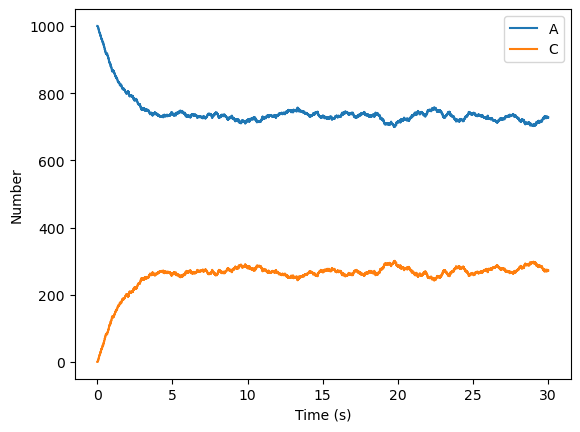

In [10]:
# Plot the traces of one replicate to see the fluctuation|
fh = openLMFile("T1.2-bimol.lm")
PostProcessing.plotTrace(fh, species=['A','C'], replicate=1)
closeLMFile(fh)

The function [```ploAvgVarFromFile```](https://luthey-schulten.chemistry.illinois.edu/software/LM2.4/_autosummary/pySTDLM.PostProcessing.html#pySTDLM.PostProcessing.plotAvgVarFromFile) will plot a list of species in one plot for all replicates. The plot will be saved in path ```outfile```. 

In [11]:
# Plot average and variance among all replicates

plotfolder = './plots_bimolecule/'

if not os.path.exists(plotfolder):
    os.mkdir(plotfolder)
    
picturepath = plotfolder + 'bimolecule_CME_{0}replicates.png'.format(reps)

PostProcessing.plotAvgVarFromFile(filename = filename, species = ['A','C'], outfile = picturepath)

<Figure size 640x480 with 0 Axes>

## Questions 1.2

1. Try plotting the average and variance of different replicates by changing ***reps*** from 10 to 200 even more. You need to restart the kernal to start a new CME simulation.

2. How many replicates are required to get a smooth average? How many for a smooth variance?

4. (Challenge) Can you derive an analytical solution for the system of equations?  Try fitting the rate constants using the results of the stochastic simulations. You may find [```scipy.optimize.curve_fit()```](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) useful for this.
5. (Challenge) Does the theoretical average number from CME always be consistent/same with the count from ODE? You may find Page 420 in McQuarrie's classic paper [STOCHASTIC APPROACH TO CHEMICAL KINETICS](https://edisciplinas.usp.br/pluginfile.php/5860923/mod_resource/content/2/McQuarrie_Gillespie.pdf) helpful. 

